In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'a-large-scale-fish-dataset' dataset.
Path to dataset files: /kaggle/input/a-large-scale-fish-dataset


In [3]:
# Main dataset directory
base_dir = os.path.join(path, "Fish_Dataset", "Fish_Dataset")

X = []  # images
y = []  # labels

# Loop through each fish species
for species in os.listdir(base_dir):
    species_path = os.path.join(base_dir, species)
    if not os.path.isdir(species_path):
        continue

    # Loop inside each fish species folder
    for subfolder in os.listdir(species_path):
        subfolder_path = os.path.join(species_path, subfolder)

        # Skip mask folders (GT = Ground Truth)
        if "GT" in subfolder or not os.path.isdir(subfolder_path):
            continue

        # Read image files
        for img_file in os.listdir(subfolder_path):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(subfolder_path, img_file)

                # Read and preprocess
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128))  # resize to standard shape

                X.append(img)
                y.append(species)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)


print("Total images:", len(X))
print("Classes:", np.unique(y))
print("Image shape:", X[0].shape)


Total images: 9000
Classes: ['Black Sea Sprat' 'Gilt-Head Bream' 'Hourse Mackerel' 'Red Mullet'
 'Red Sea Bream' 'Sea Bass' 'Shrimp' 'Striped Red Mullet' 'Trout']
Image shape: (128, 128, 3)


In [4]:
def bar_chart_cv(values, metric_name, model_name):

    folds = np.arange(1, len(values) + 1)
    mean_val = np.mean(values)

    plt.figure(figsize=(8, 5))

    bars = plt.bar(folds, values, color='skyblue')

    # Add value labels above bars
    for i, v in enumerate(values):
        plt.text(i + 1, v + 0.01, f"{v:.4f}", ha='center')

    # Mean line
    plt.axhline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f"Mean {metric_name} ({mean_val:.4f})")

    # Y-axis settings
    plt.ylim(0, 1.0)
    plt.yticks(np.arange(0, 1.01, 0.20))


    plt.title(f"{metric_name} per Fold - {model_name}")
    plt.xlabel("Fold Number")
    plt.ylabel(metric_name)

    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [5]:
def print_cv_summary(acc_scores, prec_scores, rec_scores, f1_scores, model_name):

    print(f"\n===== Cross-Validation Summary (Macro Averaged) — {model_name} =====")
    print(f"Mean Accuracy : {np.mean(acc_scores):.4f}")
    print(f"Mean Precision: {np.mean(prec_scores):.4f}")
    print(f"Mean Recall   : {np.mean(rec_scores):.4f}")
    print(f"Mean F1-score : {np.mean(f1_scores):.4f}")


## LBP Feature Extraction

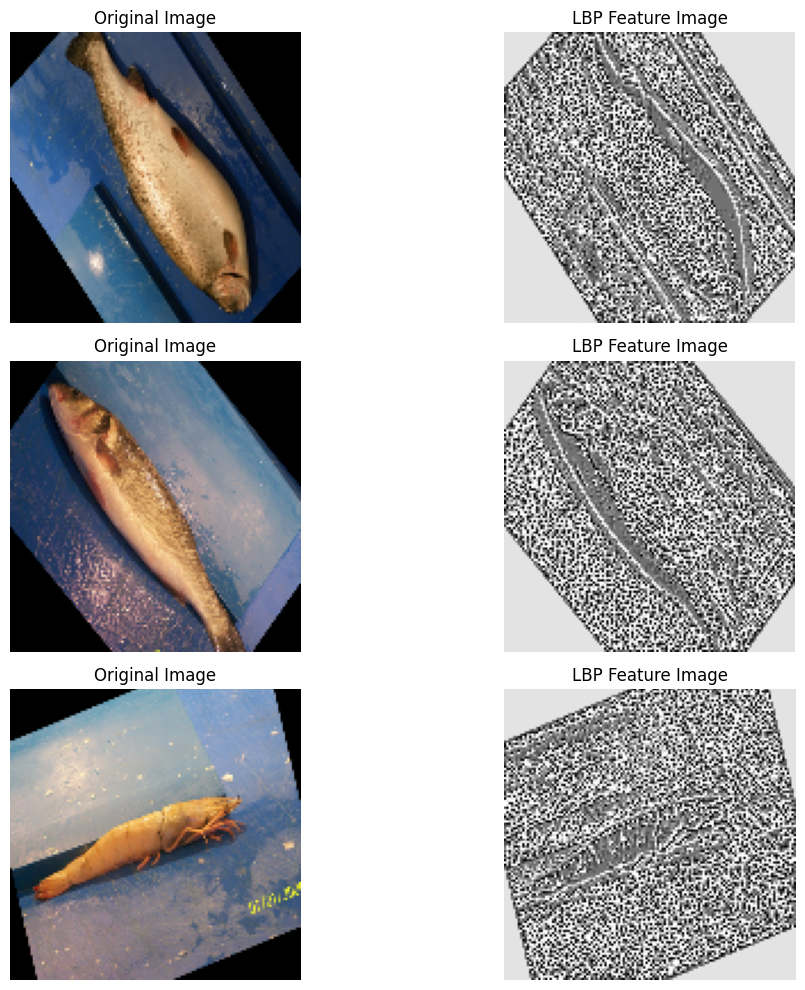

In [6]:
from skimage.feature import local_binary_pattern

# Parameters
radius = 1
n_points = 8 * radius

# LBP feature list
lbp_features = []
lbp_images = []

# Loop through all images in X
for img in X:
    # Convert to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Compute LBP
    lbp_img = local_binary_pattern(gray_image, n_points, radius, method='uniform')

    lbp_images.append(lbp_img)
    # Compute normalized histogram of LBP values
    hist, _ = np.histogram(
        lbp_img.ravel(),
        bins=np.arange(0, n_points + 3),
        range=(0, n_points + 2)
    )
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-8)  # normalization (sum = 1)

    # Save histogram as feature vector
    lbp_features.append(hist)

# Convert to NumPy array
X_lbp = np.array(lbp_features)



# Select 3 images to visualize
indices =[4070, 2287,6432]
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

for i, idx in enumerate(indices):
    img = X[idx]
    lbp_image = lbp_images[idx]

    # Original image
    axs[i, 0].imshow(img)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis('off')

    # LBP image
    axs[i, 1].imshow(lbp_image, cmap='gray')
    axs[i, 1].set_title("LBP Feature Image")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [7]:
# Split data
X_train_lbp, X_test_lbp, y_train, y_test = train_test_split(
    X_lbp, y, test_size=0.2, random_state=42
)

# Encode string labels to integers
le = LabelEncoder().fit(y_train)
n_classes = len(le.classes_)
y_train_cat = to_categorical(le.transform(y_train), num_classes=n_classes)
y_test_cat  = to_categorical(le.transform(y_test),  num_classes=n_classes)

# Scale features
scaler = StandardScaler(with_mean=False)
X_train_lbp = scaler.fit_transform(X_train_lbp)
X_test_lbp  = scaler.transform(X_test_lbp)

## ANN wiht LBP Features

In [8]:
# Build ANN model
def build_model(input_dim, num_classes=9):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

# 5-Fold Stratified Cross-Validation
X = X_train_lbp

y_labels_train = np.argmax(y_train_cat, axis=1)
num_classes = y_train_cat.shape[1]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_losses = []

# Arrays to store metrics for visualization later
acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

# variables to track the BEST fold
best_fold = None
best_val_acc = -np.inf
best_history = None
best_y_val = None
best_y_val_pred = None

print("===== 5-Fold Cross-Validation (ANN + LBP) =====")
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_labels_train), start=1):
    print(f"\n--- Fold {fold} ---")

    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y_labels_train[train_idx], y_labels_train[val_idx]

    y_tr_cat = to_categorical(y_tr, num_classes=num_classes)
    y_val_cat = to_categorical(y_val, num_classes=num_classes)

    model_cv = build_model(input_dim=X.shape[1], num_classes=num_classes)

    history_cv = model_cv.fit(
        X_tr, y_tr_cat,
        validation_data=(X_val, y_val_cat),
        epochs=200,
        batch_size=64,
        callbacks=callbacks,
        verbose=0
    )

    # Predictions
    y_val_pred = np.argmax(model_cv.predict(X_val), axis=1)

    # Compute metrics
    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro')
    rec = recall_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')

    # Save for later visualization
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

    print(f"Fold {fold} Metrics:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1-score : {f1:.4f}")


    # use the best validation accuracy reached during this fold
    fold_best_val_acc = max(history_cv.history['val_accuracy'])
    if fold_best_val_acc > best_val_acc:
        best_val_acc = fold_best_val_acc
        best_fold = fold
        best_history = history_cv
        best_y_val = y_val.copy()
        best_y_val_pred = y_val_pred.copy()


===== 5-Fold Cross-Validation (ANN + LBP) =====

--- Fold 1 ---
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 1 Metrics:
  Accuracy : 0.6069
  Precision: 0.6121
  Recall   : 0.6065
  F1-score : 0.6047

--- Fold 2 ---
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 Metrics:
  Accuracy : 0.5986
  Precision: 0.6040
  Recall   : 0.5978
  F1-score : 0.5944

--- Fold 3 ---
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3 Metrics:
  Accuracy : 0.6042
  Precision: 0.6090
  Recall   : 0.6035
  F1-score : 0.5990

--- Fold 4 ---
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 Metrics:
  Accuracy : 0.5771
  Precision: 0.5861
  Recall   : 0.5765
  F1-score : 0.5744

--- Fold 5 ---
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 5 Metrics:
  Accuracy : 0.5910
  Precision: 0.6024
  Recall   : 0.5903
  F1-score : 0.5892


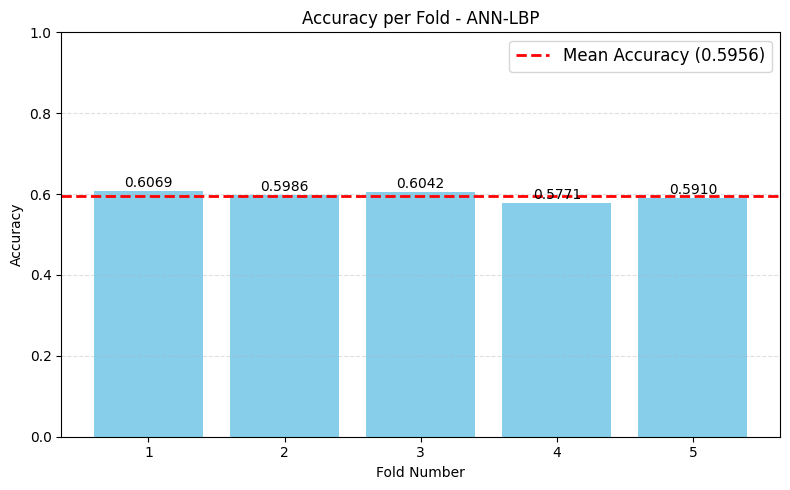

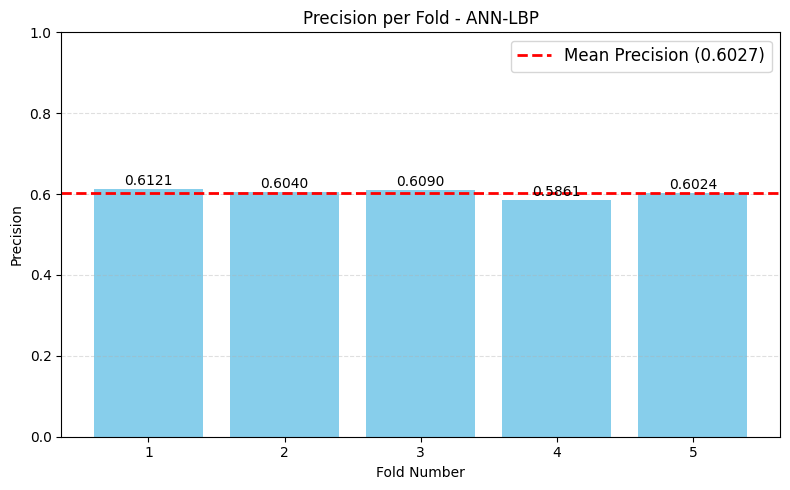

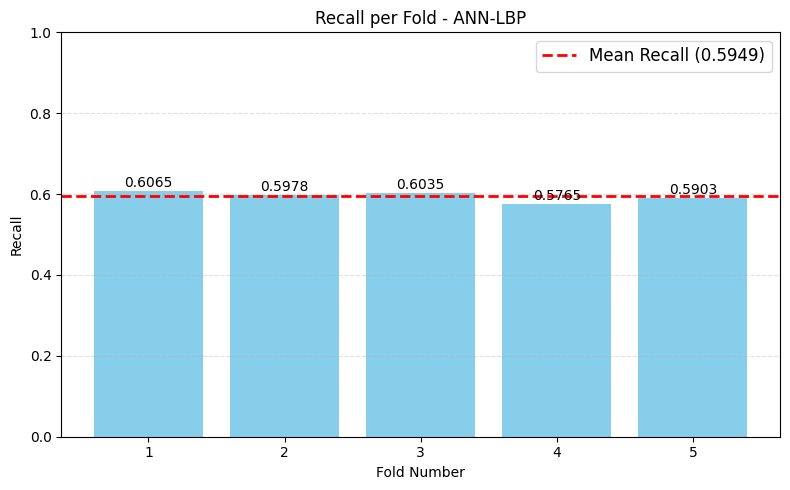

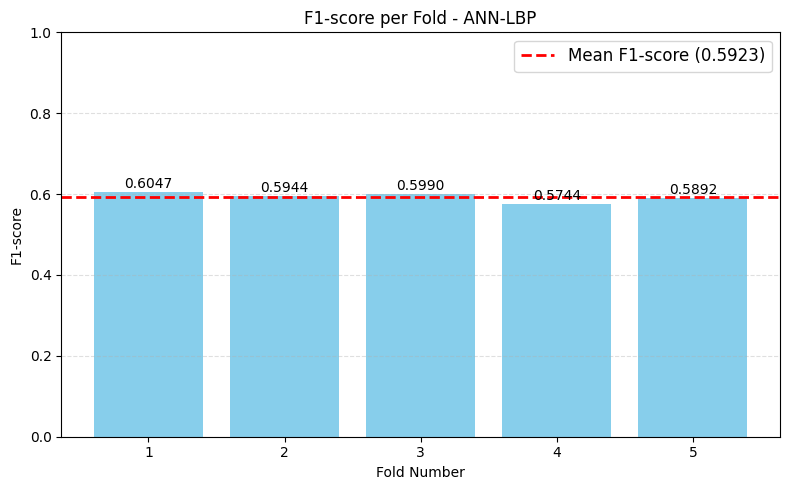


===== Cross-Validation Summary (Macro Averaged) — ANN-LBP =====
Mean Accuracy : 0.5956
Mean Precision: 0.6027
Mean Recall   : 0.5949
Mean F1-score : 0.5923


In [9]:
bar_chart_cv(acc_scores, metric_name="Accuracy", model_name="ANN-LBP")
bar_chart_cv(prec_scores, metric_name="Precision", model_name="ANN-LBP")
bar_chart_cv(rec_scores, metric_name="Recall", model_name="ANN-LBP")
bar_chart_cv(f1_scores, metric_name="F1-score", model_name="ANN-LBP")


print_cv_summary(acc_scores, prec_scores, rec_scores, f1_scores, model_name="ANN-LBP")

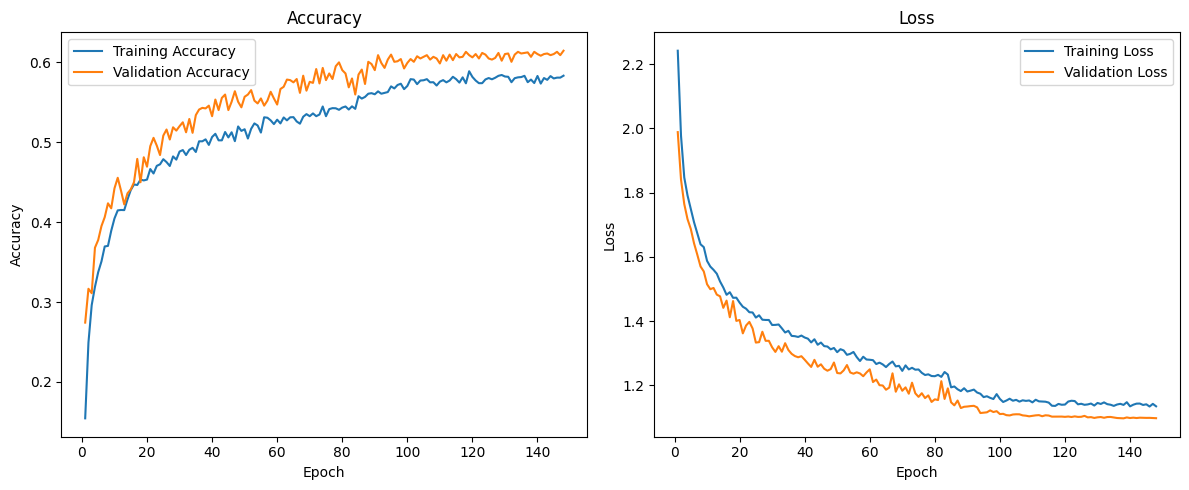

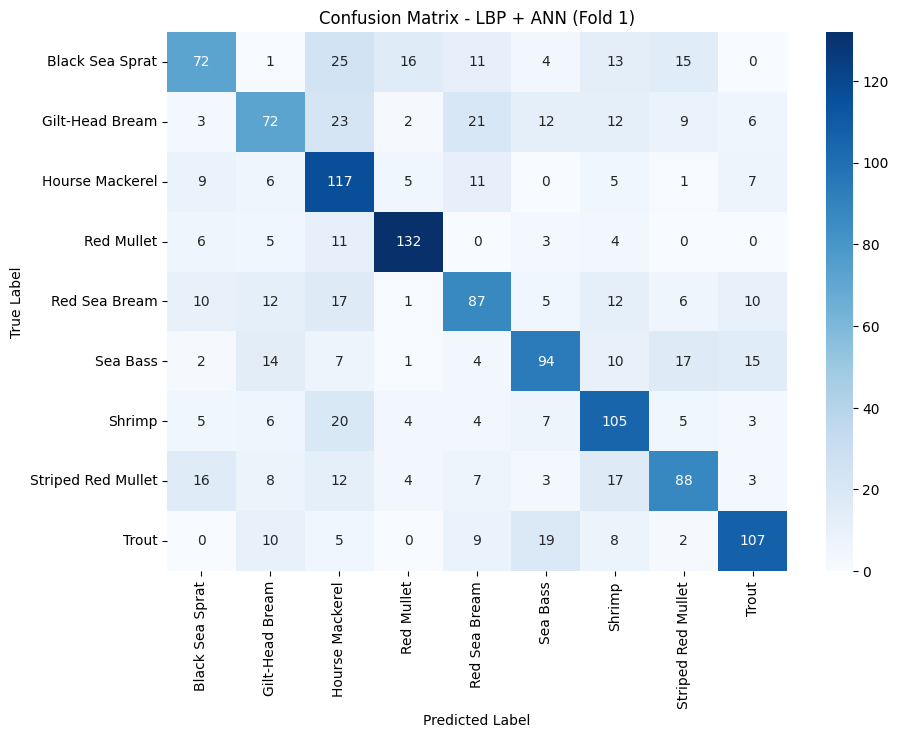

In [10]:
# Plot Accuracy & Loss for BEST fold
epochs_range = range(1, len(best_history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, best_history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, best_history.history['loss'], label='Training Loss')
plt.plot(epochs_range, best_history.history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("\n")
# Confusion Matrix for BEST fold
cm = confusion_matrix(best_y_val, best_y_val_pred)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - LBP + ANN (Fold {best_fold})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## KNN with LBP Features

In [11]:
def build_knn():
    return KNeighborsClassifier(
        n_neighbors=10,
        metric='euclidean',
        weights='distance'
    )

# Arrays to collect metrics
acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

# BEST FOLD tracking variables
best_fold = None
best_acc = -1
best_y_val = None
best_y_val_pred = None
best_knn_model = None
best_val_idx = None   # optional: to retrieve actual validation data later

# Prepare labels
y_labels_train = y_train
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("===== 5-Fold Cross Validation — KNN + LBP =====")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_lbp, y_labels_train), start=1):

    X_tr, X_val = X_train_lbp[train_idx], X_train_lbp[val_idx]
    y_tr, y_val = y_labels_train[train_idx], y_labels_train[val_idx]

    # Create model using function
    knn_cv = build_knn()
    knn_cv.fit(X_tr, y_tr)

    y_val_pred = knn_cv.predict(X_val)

    # Metrics
    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro')
    rec = recall_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')

    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

    print(f"\n--- Fold {fold} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    # SAVE BEST FOLD
    if acc > best_acc:
        best_acc = acc
        best_fold = fold
        best_y_val = y_val.copy()
        best_y_val_pred = y_val_pred.copy()
        best_knn_model = knn_cv
        best_val_idx = val_idx.copy()


===== 5-Fold Cross Validation — KNN + LBP =====

--- Fold 1 ---
Accuracy : 0.8562
Precision: 0.8579
Recall   : 0.8563
F1-score : 0.8563

--- Fold 2 ---
Accuracy : 0.8424
Precision: 0.8448
Recall   : 0.8422
F1-score : 0.8420

--- Fold 3 ---
Accuracy : 0.8431
Precision: 0.8440
Recall   : 0.8427
F1-score : 0.8426

--- Fold 4 ---
Accuracy : 0.8486
Precision: 0.8537
Recall   : 0.8484
F1-score : 0.8491

--- Fold 5 ---
Accuracy : 0.8403
Precision: 0.8411
Recall   : 0.8403
F1-score : 0.8399


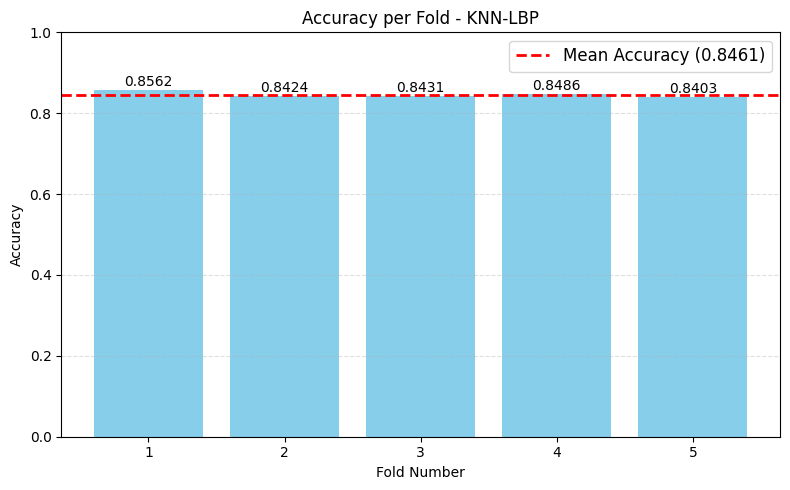

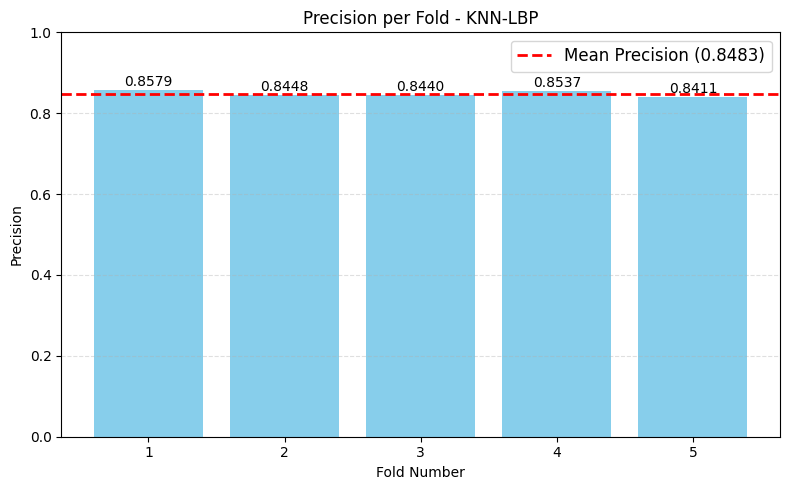

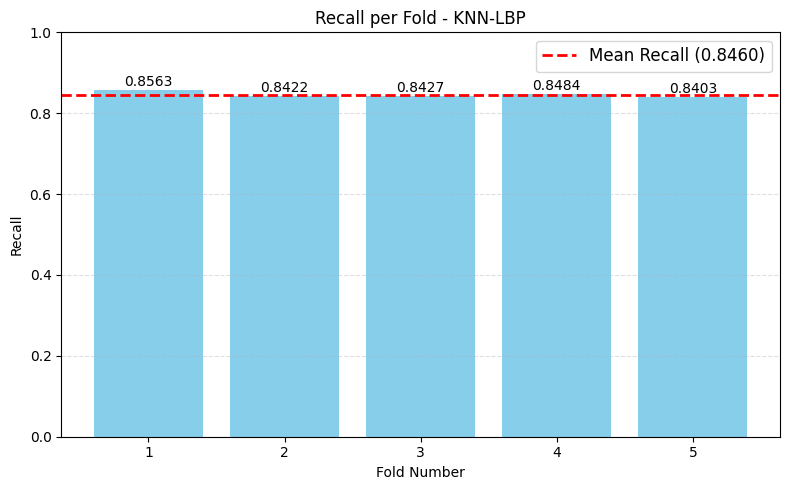

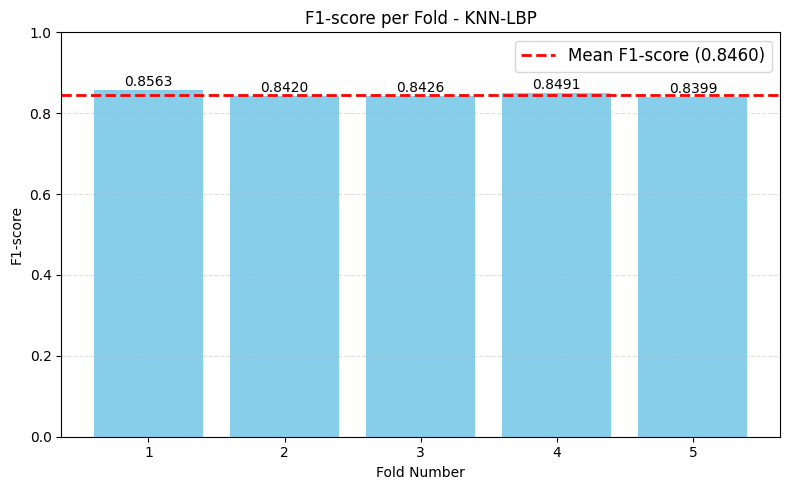


===== Cross-Validation Summary (Macro Averaged) — KNN-LBP =====
Mean Accuracy : 0.8461
Mean Precision: 0.8483
Mean Recall   : 0.8460
Mean F1-score : 0.8460


In [12]:
bar_chart_cv(acc_scores, metric_name="Accuracy", model_name="KNN-LBP")
bar_chart_cv(prec_scores, metric_name="Precision", model_name="KNN-LBP")
bar_chart_cv(rec_scores, metric_name="Recall", model_name="KNN-LBP")
bar_chart_cv(f1_scores, metric_name="F1-score", model_name="KNN-LBP")

print_cv_summary(acc_scores, prec_scores, rec_scores, f1_scores, model_name="KNN-LBP")


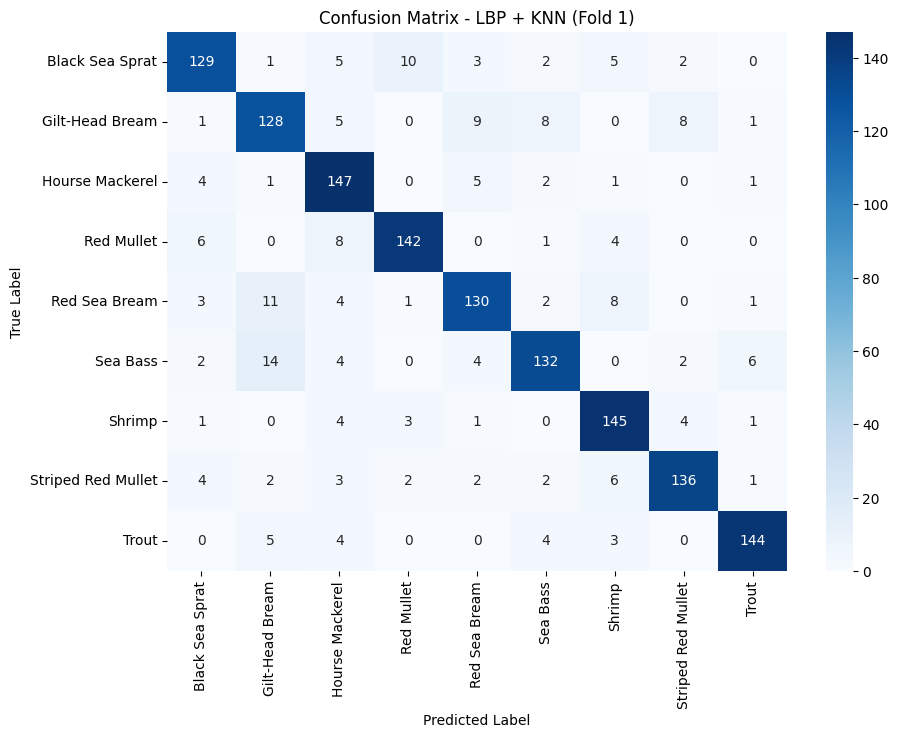

In [13]:
# Confusion Matrix for BEST fold
cm = confusion_matrix(best_y_val, best_y_val_pred)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - LBP + KNN (Fold {best_fold})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM with LBP Features

In [15]:
def build_svm():
    return SVC(
        kernel='rbf',
        C=100,
        gamma=0.1,
        decision_function_shape='ovr',
        random_state=42
    )

print("===== 5-Fold Cross Validation — SVM + LBP =====")

# arrays to store metrics
acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

# variables to track the BEST fold
best_fold = None
best_val_acc = -np.inf
best_model = None
best_y_val = None
best_y_val_pred = None

y_labels_train = y_train
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_lbp, y_labels_train), start=1):
    X_tr, X_val = X_train_lbp[train_idx], X_train_lbp[val_idx]
    y_tr, y_val = y_labels_train[train_idx], y_labels_train[val_idx]

    # build and train SVM
    svm_cv = build_svm()
    svm_cv.fit(X_tr, y_tr)

    # predictions
    y_val_pred = svm_cv.predict(X_val)

    # metrics
    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro')
    rec = recall_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')

    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

    print(f"\n--- Fold {fold} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")


    if acc > best_val_acc:
        best_val_acc = acc
        best_fold = fold
        best_model = svm_cv
        best_y_val = y_val
        best_y_val_pred = y_val_pred


===== 5-Fold Cross Validation — SVM + LBP =====

--- Fold 1 ---
Accuracy : 0.7458
Precision: 0.7527
Recall   : 0.7455
F1-score : 0.7470

--- Fold 2 ---
Accuracy : 0.6931
Precision: 0.7020
Recall   : 0.6926
F1-score : 0.6941

--- Fold 3 ---
Accuracy : 0.7125
Precision: 0.7150
Recall   : 0.7120
F1-score : 0.7114

--- Fold 4 ---
Accuracy : 0.7181
Precision: 0.7226
Recall   : 0.7177
F1-score : 0.7172

--- Fold 5 ---
Accuracy : 0.6931
Precision: 0.6974
Recall   : 0.6926
F1-score : 0.6933


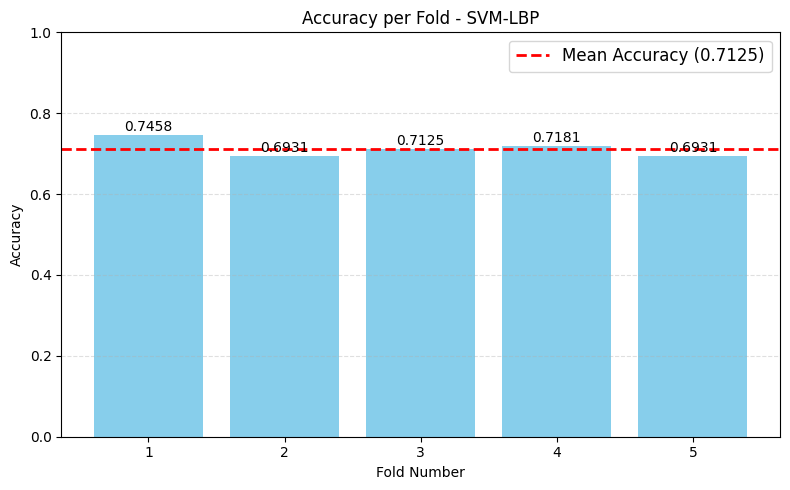

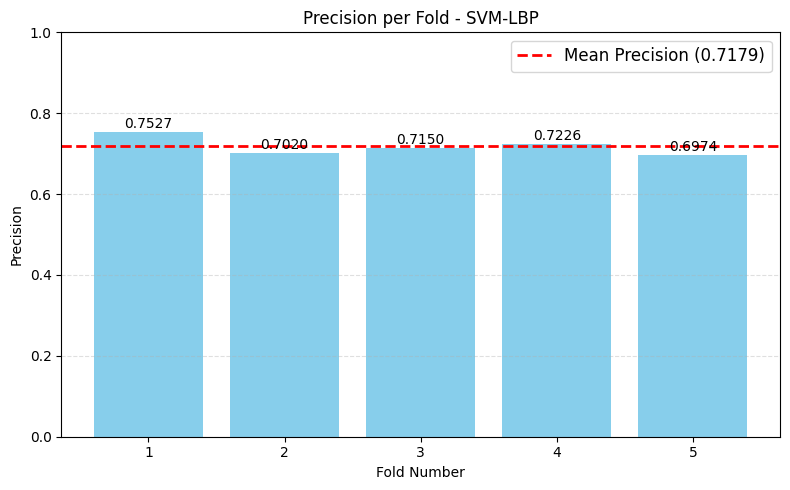

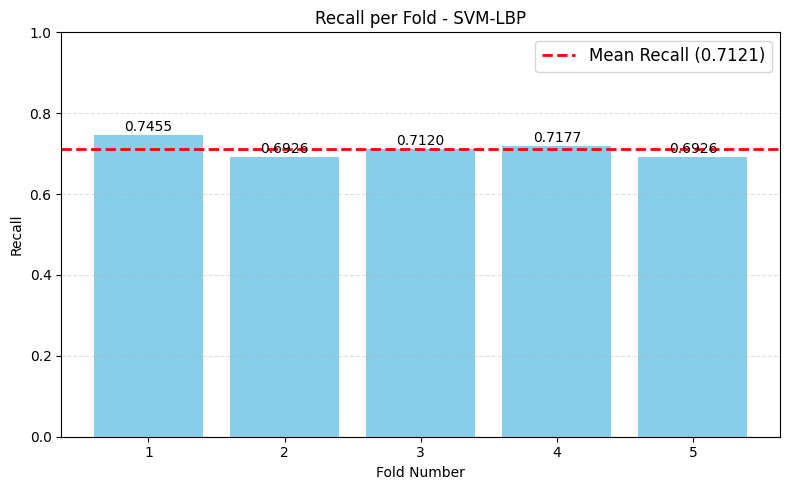

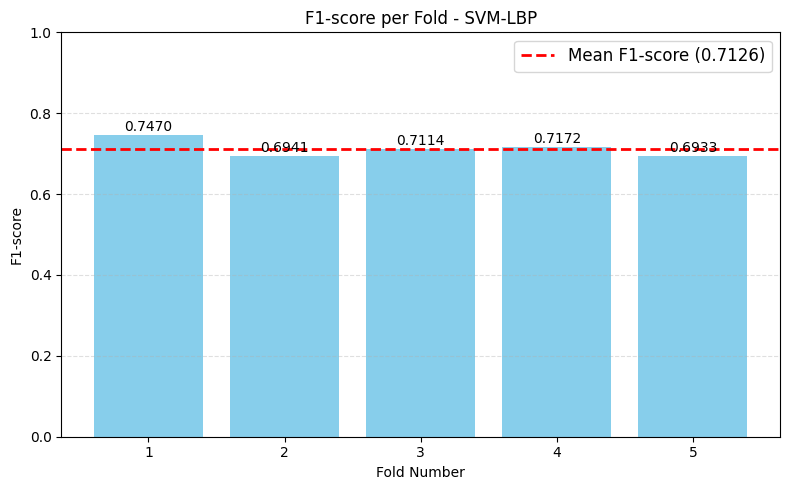


===== Cross-Validation Summary (Macro Averaged) — SVM-LBP =====
Mean Accuracy : 0.7125
Mean Precision: 0.7179
Mean Recall   : 0.7121
Mean F1-score : 0.7126


In [16]:
bar_chart_cv(acc_scores, metric_name="Accuracy",  model_name="SVM-LBP")
bar_chart_cv(prec_scores, metric_name="Precision", model_name="SVM-LBP")
bar_chart_cv(rec_scores, metric_name="Recall",    model_name="SVM-LBP")
bar_chart_cv(f1_scores,  metric_name="F1-score",  model_name="SVM-LBP")

print_cv_summary(acc_scores, prec_scores, rec_scores, f1_scores, model_name="SVM-LBP")


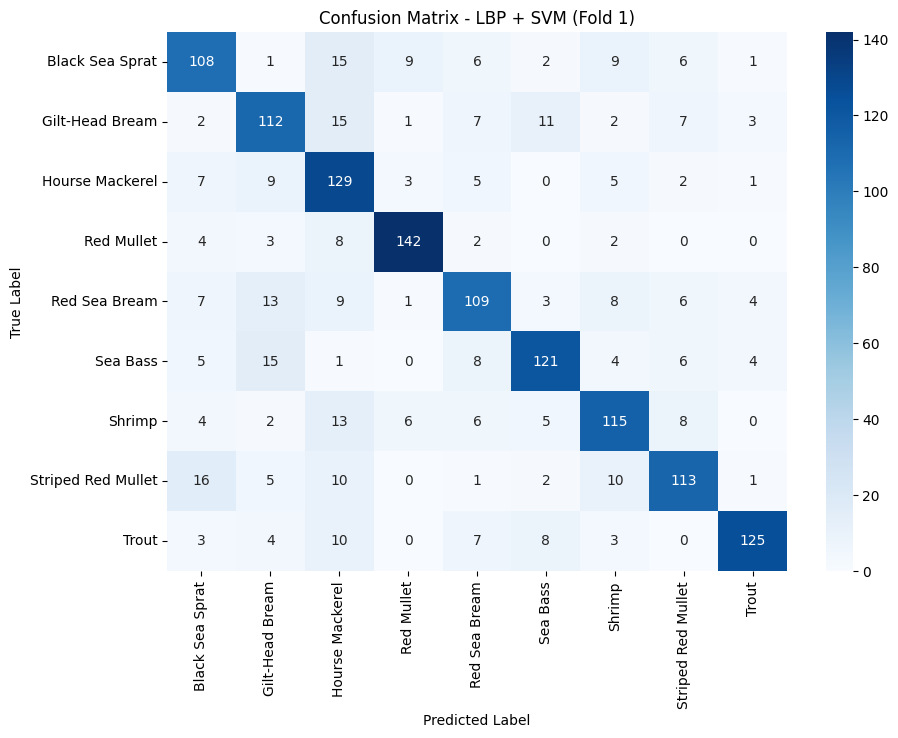

In [17]:
# Confusion Matrix for BEST fold
cm = confusion_matrix(best_y_val, best_y_val_pred)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - LBP + SVM (Fold {best_fold})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()